In [1]:
import os
import time
import json
import parse
import fasttext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])
from utils import *
from sklearn.metrics import f1_score

files = !ls backup*.txt


df = pd.concat(
    [read_record(file) for file in [
    #"backup_12.txt",
    #"backup_12_1.txt",
    #"backup_12_2.txt",
    "backup_17.txt",
    "backup_17__2.txt",
    "backup_18.txt",
    "backup_18_2.txt",
    "backup_20.txt",
    "backup_20_2.txt",
    "backup_20.txt",
    "backup_20_2.txt"
    ]], ignore_index=True)



In [2]:
df.train.unique()

array(['full', 'dd', 'ok', 'secondary_dd', 'traindev_dd', 'minitrain_dd'],
      dtype=object)

In [3]:
c = df.train.isin("dd,traindev_dd,minitrain_dd".split(","))
c2 = df["eval"] == "test_dd"
df = df[c & c2]
df = df.dropna(axis=0).reset_index()

In [4]:
df["y_pred"] = df.y_pred.apply(to_label)
df["y_true"] = df.y_true.apply(to_label)

In [5]:
df.sample(5)

,index,microF1,macroF1,train,eval,y_true,y_pred
5,75,0.599,0.593,dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."
22,139,0.599,0.488,minitrain_dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."
21,138,0.629,0.538,minitrain_dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."
11,128,0.629,0.538,minitrain_dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."
8,125,0.624,0.577,traindev_dd,test_dd,"[Promotion of a Product, Promotion of a Produc...","[Promotion of a Product, Promotion of a Produc..."


# Constructing the data for the barh plot

In [6]:
original = pd.read_csv("/home/peterr/macocu/task5_webgenres/data/interim/tabular_1d.csv")
length = original.shape[0]
percentages = dict()
for label in train_labels_no_prefix:
    percentages[label] = len(original[original.primary==label])/length
del original

In [7]:
to_plot = dict()
to_plot["frequency"] = percentages


for name, setting in zip(["40%", "60%", "80%"],["minitrain_dd", "dd", "traindev_dd"]):
    subset = df[df.train == setting].copy()
    y_trues = list()
    for l in subset.y_true.values:
        y_trues.extend(l)
    y_preds = list()
    for l in subset.y_pred.values:
        y_preds.extend(l)
    from sklearn.metrics import f1_score
    f1s = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average=None)
    current = {label: f1 for label, f1 in zip(train_labels_no_prefix, f1s)}
    macrof1 = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average="macro")
    current["macroF1"] = macrof1
    microf1 = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average="micro")
    current["microF1"] = microf1
    to_plot[name] = current



In [8]:
pd.DataFrame(to_plot)

,frequency,40%,60%,80%
Legal/Regulation,0.017,0.333,0.800,0.833
Opinionated News,0.089,0.582,0.635,0.615
News/Reporting,0.115,0.601,0.623,0.619
Forum,0.052,0.893,0.894,0.862
Correspondence,0.016,0.489,0.698,0.566
Invitation,0.032,0.568,0.475,0.575
Instruction,0.038,0.676,0.697,0.519
Recipe,0.006,1.000,1.000,1.000
Opinion/Argumentation,0.114,0.466,0.447,0.482
Promotion of Services,0.032,0.533,0.538,0.694


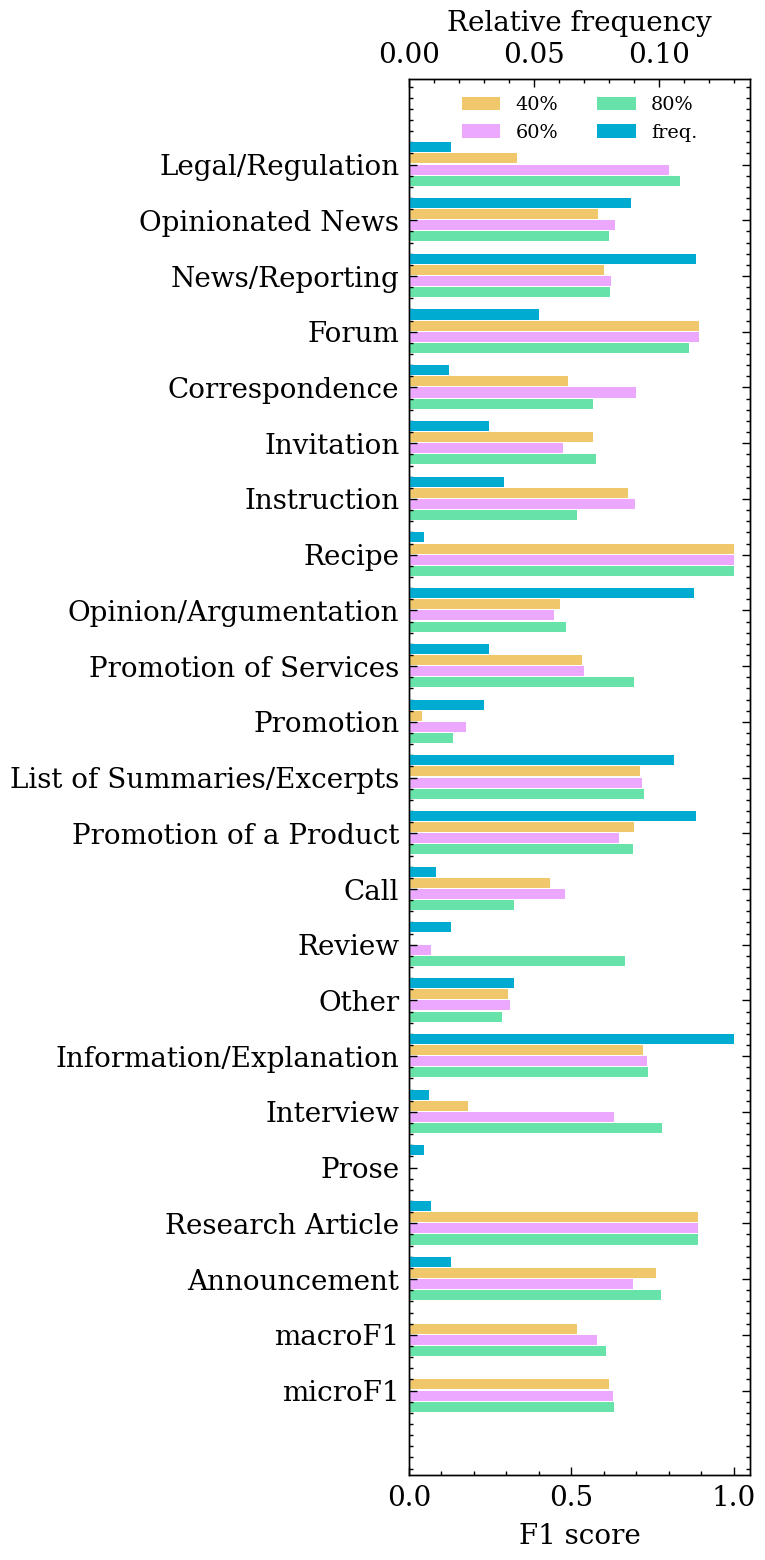

In [9]:
plotdf = pd.DataFrame(to_plot)
fig, ax = plt.subplots(figsize=(4,8), dpi=200)
spread_factor = 5
labels = train_labels_no_prefix + ["macroF1", "microF1"]
ind = np.arange(len(labels))*spread_factor

col = "40%"
sep = 1
height = 0.9
lines = list()

colors = ["#f1c76b",
"#eba8fe",
"#67e3a9",
"#00abd2"]
for i, col in enumerate(["40%", "60%", "80%"]):
    lines.append(ax.barh(ind+(i-2)*sep, plotdf[col].values, height=height, label=col, color=colors[i],
    align = "edge"))
ax.set_yticks(ind-1*sep)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel("F1 score")

ax2 = plt.twiny(ax)
lines.append(ax2.barh(ind-3*sep, plotdf["frequency"].values, 
        height=height, 
        label="freq.", 
        color=colors[-1],
        align="edge"))

ax2.set_xlabel("Relative frequency")

labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize="x-small", ncol=2, loc=9)
plt.tight_layout()
plt.savefig("paper/Q3_2.png")
plt.savefig("paper/Q3_2.pdf")
plt.show()


# Q2 significance

In [39]:
df = pd.concat(
    [read_record(file) for file in [
    # "backup_12.txt",
    #"backup_12_1.txt",
    #"backup_12_2.txt",
    # "backup_15.txt",
    # "backup_16.txt",
    "backup_17.txt",
    #"backup_17__2.txt",
    "backup_18.txt",
    #"backup_18_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt"
    ]], ignore_index=True)

In [40]:
c1 = df.train == "dd"
c2 = df.train == "secondary_dd"

c = df["eval"] == "test_dd"

nruns = min(df[c & c2].shape[0], df[c & c1].shape[0])
nruns

5

In [41]:
from scipy import stats

# Macro F1:
#Candidate:
higher = df.loc[c & c1,"macroF1"][:nruns]
#Alternative
lower = df.loc[c & c2, "macroF1"][:nruns]

# print(f"Wilcoxon p value: {stats.wilcoxon(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"Student p value: {stats.ttest_ind(higher,lower)[1]:0.3}", "\t\t(null hypothesis: samples have identical average, equal variance is assumed but not necessary)")
import numpy as np
print(f"Higher average: {np.mean(higher):0.4}, lower average: {np.mean(lower):0.4}")

MannWhithey p value: 0.00609 		(alternative hypothesis: first is greater than the second)
Student p value: 0.00241 		(null hypothesis: samples have identical average, equal variance is assumed but not necessary)
Higher average: 0.6074, lower average: 0.5379


In [42]:
# Micro F1:
#Candidate:
higher = df.loc[c & c1,"microF1"][:nruns]
#Alternative
lower = df.loc[c & c2, "microF1"][:nruns]

# print(f"Wilcoxon p value: {stats.wilcoxon(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"MannWhithey p value: {stats.mannwhitneyu(higher,lower, alternative='greater')[1]:0.3}", "\t\t(alternative hypothesis: first is greater than the second)")

print(f"Student p value: {stats.ttest_ind(higher,lower)[1]:0.3}", "\t\t(null hypothesis: samples have identical average, equal variance is assumed but not necessary)")
import numpy as np
print(f"Higher average: {np.mean(higher):0.4}, lower average: {np.mean(lower):0.4}")

MannWhithey p value: 0.102 		(alternative hypothesis: first is greater than the second)
Student p value: 0.308 		(null hypothesis: samples have identical average, equal variance is assumed but not necessary)
Higher average: 0.6335, lower average: 0.6234


# Q4 : does downcasting labels improve results?

In [43]:
df = pd.concat(
    [read_record(file) for file in [
    # "backup_12.txt",
    #"backup_12_1.txt",
    #"backup_12_2.txt",
    # "backup_15.txt",
    # "backup_16.txt",
    #"backup_17.txt",
    #"backup_17__2.txt",
    #"backup_18.txt",
    #"backup_18_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt",
    # "backup_20.txt",
    # "backup_20_2.txt"
    "backup_21.txt",
    ]], ignore_index=True)
df

,microF1,macroF1,y_true,y_pred,train,eval
0,0.706,0.368,"[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
1,0.688,0.399,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
2,0.701,0.393,"[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
3,0.683,0.376,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
4,0.675,0.399,"[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
5,0.673,0.389,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
6,0.706,0.357,"[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
7,0.678,0.373,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
8,0.695,0.392,"[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
9,0.673,0.373,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd


In [52]:
a = 1
for i in range(10):
    print(a)
    a = a * 1.61
    a = int(round(a, 0))


1
2
3
5
8
13
21
34
55
89
